<a href="https://colab.research.google.com/github/yueliyl/viprs-tut/blob/main/Inference%20of%20Polygenic%20Risk%20Scores%20from%20Biobank%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Inference of Polygenic Risk Scores from Biobank Data</h2>

**Original Author**: Shadi Zabad and modified by Yue Li

Quick links:

* [Shadi Zabad GitHub Page](https://github.com/shz9/viprs)
* [Yue Li Lab website](https://www.cs.mcgill.ca/~yueli/) | [Simon Gravel Lab website](https://gravellab.github.io/)

* [`viprs` package](https://shz9.github.io/viprs/) | [`magenpy` package](https://shz9.github.io/magenpy/)
* [VIPRS AJHG Manuscript](https://doi.org/10.1016/j.ajhg.2023.03.009)

### Environment setup / Required packages

This tutorial requires:
    
* `python>=3.8`
* Jupyter notebook.

#### Install required packages

In [23]:
import warnings
warnings.filterwarnings("ignore") # ignore warnings

!pip install magenpy>=0.1.1 matplotlib scikit-learn
!pip install --quiet pandas==2.2.1
!pip install --quiet git+https://github.com/yueliyl/viprs # ignore pandas error
!pip install xarray==2023.10.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
os._exit(0) # restart colab kernel to load the installed magenpy

**Note**: If you encounter issues installing `viprs` or `magenpy` in your environment, please follow the installation guide on the [documentation website](https://shz9.github.io/viprs/installation/#installation). In particular, it may be helpful to setup the environment with `conda` before proceeding with the installation.

#### Import main packages

In [1]:
import numpy as np
import pandas as pd
import magenpy as mgp
import viprs as vp
import matplotlib.pyplot as plt

# Introduction

In Statistical Genetics, Polygenic Risk Scores (PRS) are a **predictive tool**:
They allow us to assess someone's **lifetime risk of disease based on their DNA sequence alone**. This, of course,
hinges on us knowing which genetic variants are associated with a given disease, and which alleles are *risk-increasing* in the population. This is why discussions of PRS and PRS methods are often tied to the main powerhouse of modern medical genetics: **Genome-wide Association Studies (GWASs)**. GWASs are a powerful methodology for detecting statistical associations between genetic variants and disease in a given study cohort. With increasing sample sizes and improved statistical methodologies in recent GWAS analyses, interest in using their insights for developing more accurate polygenic scores has become an important priority.

<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/prs_intro.png?raw=1" alt="drawing" width="500"/>

### What are Polygenic Scores useful for?

Among the many promising applications of polygenic risk scores in genomic medicine, the following areas have received the most attention:

<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/prs_applications.png?raw=1" alt="drawing" width="1000"/>

## Outline / Table of Contents

This hands-on tutorial will explain how we can go about inferring polygenic scores from biobank data.
Specifically, we will discuss the following important concepts and considerations that are important to understand
polygenic score and the methods used to infer them:

- [(0) The Data: The data needed for Inference of Polygenic Scores.](#(0)-The-Data:-The-data-needed-for-Inference-of-Polygenic-Scores.)
    - [(0.1) Genotype data]((0.1)-Genotype-data)
    - [(0.2) Phenotype data](#(0.2)-Phenotype-data)
- [(1) Modeling the relationship between Genotypes and Complex Traits](#(1)-Modeling-the-Relationship-between-Genotypes-and-Complex-Traits)
    - [(1.1) The Linear Model](#(1.1)-The-Linear-Model)
    - [(1.2) The effect sizes $\beta$](#(1.2)-The-effect-sizes-$\beta$)
    - [(1.3) Assumptions about the distribution of effect sizes](#(1.3)-Assumptions-about-the-distribution-of-effect-sizes)
    - [(1.4) Heritability](#(1.4)-Heritability)
- [(2) Simulating Complex Traits using `magenpy`](#(2)-Simulating-Complex-Traits-using-magenpy)
- [(3) Inference of Polygenic Risk Scores (PRS) from Individual-level Data](#(3)-Inference-of-Polygenic-Risk-Scores-(PRS)-from-Individual-level-Data)
    - [(3.1) Multiple Linear Regression](#(3.1)-Multiple-Linear-Regression)
    - [(3.2) Regularized Linear Regression](#(3.2)-Regularized-Linear-Regression)
- [(4) Inference of Polygenic Risk Scores (PRS) from GWAS Summary Statistics](#(4)-Inference-of-Polygenic-Risk-Scores-(PRS)-from-GWAS-Summary-Statistics)
    - [(4.1) Naive PRS](#(4.1)-Naive-PRS)
    - [(4.2) Clumping + Thresholding (C+T)](#(4.2)-Clumping-+-Thresholding-(C+T))
    - [(4.3) Bayesian PRS (`VIPRS`)](#(4.3)-Bayesian-PRS-(VIPRS))
- [(5) PRS Evaluation Strategies / Metrics](#(5)-PRS-Evaluation-Strategies-/-Metrics)
- [(6) Inference of Polygenic Risk Scores (PRS) from Publicly Available GWAS Summary Statistics](#(6)-Inference-of-Polygenic-Risk-Scores-(PRS)-from-Publicly-Available-GWAS-Summary-Statistics)


## (0) The Data: The data needed for Inference of Polygenic Scores.

Recall that polygenic scores are a predictive tool: They map from the space of DNA (i.e. genetic variants) to
to the space of phenotypes (e.g. disease status or continuous phenotype, such as height).

Therefore, in order for us to infer polygenic scores and learn this mapping, we need access to **matched genotype
and phenotype data** from the same set of individuals.

<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/genetic_data.png?raw=1" alt="drawing" width="600"/>


### (0.1) Genotype data

Learning polygenic scores requires precisely defining the input data used to generate the prediction. Similar to
GWAS settings, **the input for each individual is the number of non-reference alleles (i.e. mutations) at a particular position in the genome**. Which allele is considered reference here is arbitrary, though typically in many applications the more common allele in the population is taken as reference.

For our purposes here, we will mainly focus on **Single Nucleotide Polymorphisms (SNPs)**, that, as the name suggests, record differences in a single DNA nucleotide between individuals in the population. Furthermore, we will consider only **bi-allelic variants**: i.e. only 2 alleles, such as A and G, are present in the population.

#### Example Genotype Data from 1000G Project

To make things concrete, let's look at some real genotype data from the 1000G Project. The package `magenpy`, which we installed / imported at the beginning of this tutorial, is shipped with genotype data for about ~15,000 SNPs and 378 individuals of European ancestry.

We will load the genotype data from disk using the `xarray` backend and inspect its characteristics:

In [2]:
from magenpy.GenotypeMatrix import xarrayGenotypeMatrix

# Load the genotype matrix by providing path to BED file:
g_matrix = xarrayGenotypeMatrix.from_file(mgp.tgp_eur_data_path())
# Inspect the xarray object:
g_matrix.xr_mat

<xarray.DataArray 'genotype' (sample: 378, variant: 15938)>
dask.array<transpose, shape=(378, 15938), dtype=float32, chunksize=(378, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * sample   (sample) <U7 'HG00096' 'HG00097' 'HG00099' ... 'NA20826' 'NA20828'
  * variant  (variant) <U12 'variant0' 'variant1' ... 'variant15937'
    fid      (sample) object 'HG00096' 'HG00097' ... 'NA20826' 'NA20828'
    iid      (sample) object 'HG00096' 'HG00097' ... 'NA20826' 'NA20828'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    ...       ...
    chrom    (variant) object '22' '22' '22' '22' '22' ... '22' '22' '22' '22'
    snp      (variant) object 'rs131538' 'rs9605903' ... 'rs28729663'
    cm       (variant) float64 2.236 2.336 2.34 2.344 ... 75.08 75.09 75.12
    pos      (variant) int32 16871137 17054720 17057138 ... 51178090 51219006
    a0       (variant) object 'A' 'C' 'G' 'T' 'A' 'C' ... 'A' 'A' 'G' 'A' 'A'
    a1       (variant) object 'G' 'T' 'T' 'C' 'T' 'T' ... 'G' 'G' 'A' 'G' 'G'

This representation is known as a `DataArray` and it summarizes the matrix itself (its shape, size, etc.)
but also the characteristics of the the two main dimensions:
    
* The `sample` dimension contains information about the individuals, such as their IDs, gender, etc.
* The `variant` dimension contains information about the SNPs, such as their IDs, genomic position, reference and alternative alleles, etc.

To examine the contents of the genotype matrix itself (i.e. the mutation counts), we can load the data into
memory and represent using `numpy` arrays:

In [3]:
np_matrix = g_matrix.to_numpy()
print(np_matrix.shape)

(378, 15938)


### Quick Exercise (1): For each variant, count how many mutations are present in the entire sample

In [4]:
#@title YOUR CODE


In [5]:
#@title SOLUTION
print(np_matrix.sum(axis=0)) # minor allele count
print(np_matrix.sum(axis=0)/np_matrix.shape[0]) # minor allele freq

[ 50 200  40 ...  47  45 121]
[0.13227513 0.52910053 0.10582011 ... 0.12433862 0.11904762 0.32010582]


### (0.2) Phenotype data

In the context of PRS, phenotype data encomposses **measurements, diagnoses, health records, or self-reports** that are specific to each individual. Historically, the most well-studied phenotypes have been relatively easy to measure and define, primarily anthropomorphic traits such as height, weight, and Body Mass Index (BMI). These phenotypes display continuous variation in the population, which is why they are often referred to as **quantitative traits**. Another class of phenotypes that have also been well studied are **case-control or binary** phenotypes, primarily disease diagnoses, such as whether the subject has been diagonsed with Type 2 Diabetes, Heart Disease, and Alzheimer.

More recently, with the emergence of large-scale genetic biobanks that are paired with **Electronic Health Records (EHR)**, everything from **medication use** to **self-reports of insomnia** have been defined as phenotypes and studied in the context of GWAS and PRS. More interestingly, computational post-processing of these raw EHR records could also result in **"computationally-defined" phenotypes** that are useful for some downstream applications.

Unfortunately, the 1000G project does not come with phenotype data for us to inspect, but we can easily simulate
complex traits, as we will discuss in the next section.

## (1) Modeling the Relationship between Genotypes and Complex Traits

Learning a predictor between any two modalities always proceeds by first defining a model. A model is not
a mechanism, it doesn't define precisely how the input `X` influences the output `y` in every detail. It's a way for researchers to encode our assumptions about the dependence between input and output. In the context of statistical genetics and complex traits, the dependence between genotype and phenotype was understood, analyzed, and interrogated using the linear model.

### (1.1) The Linear Model

The linear model is the simplest possible way to parametrize the dependence between the phenotype and genotype. It assumes that each genetic variant influences the phenotype **additively** (i.e. without interaction or dependence on other variants), and the **magnitude/direction of influence** is parametrized by a quantitative parameter typically denoted by $\beta$:

$$
y_i = \textbf{X}_i\beta + \epsilon_i = \sum_{j=1}^M X_{ij}\beta_j + \epsilon_i
$$

This equation tells us that the phenotype of individual $i$ is the sum of their genotype (i.e. number of mutations they carry) at each position, weighted by the **effect size** $\beta$. Here, $M$ denotes that total number of genetic variants in our study. The variable $\epsilon$ is known as the **residual**, capturing all non-additive and non-genetic effects on the phenotype.

To make things more concrete, let's focus on a simple case where there are only 2 genetic variants $X_1$ and $X_2$. We will assume that:

* Variant 1 has an effect of $\beta_1 = 10$ on the phenotype.
* Variant 2 has an effect of $\beta_2 = -3$ on the phenotype.

Furthermore, let's assume that individual $i$ carries:

* 1 mutation on the first variant $X_1$
* 2 mutations on the second variant $X_2$
    
Assuming this phenotype does not have any non-genetic / non-additive influences ($\epsilon = 0$), we get that the phenotype for individual $i$ is:

$$
y_i = X_1*\beta_1 + X_2*\beta_2 = 1*10 + 2*(-3) = 4
$$


This simple model is the basis for most statistical genetics analyses and tools, from GWAS to PRS. In the context of the linear model, the **prediction (or polygenic score) for individual $i$ is simply defined as**:

$$
PRS_i = \hat{y}_i = \sum_{j=1}^M X_{ij}*\hat{\beta}_j
$$

Note that the hat $\hat{\beta}_j$ is used here to indicate that the effects are **estimated** from data.

### (1.2) The effect sizes $\beta$

As mentioned above, the $\beta$ parameter is a simple weight that captures the magnitude and direction of the effect on phenotype. The magnitude (absolute value) of the effect ($|\beta|$) tells us about the strength of this effect. In the example above, variant 1 had a much larger effect, in absolute terms, on the phenotype than variant 2. The direction (i.e. sign) also conveys important information:

* Variants / alleles with **positive $\beta$ will increase** the phenotype.
* Variants / alleles with **negative $\beta$ will decrease** the phenotype.

**Note**: We say "variants / alleles" here because this depends on how we choose our "reference allele" when we construct the genotype matrix. If the reference allele is changed, the effect direction will flip.

A natural consequence of the above definitions is that **variants whose weight is set to zero (i.e. $\beta = 0$) will have no effect on the phenotype**.

A **central question in statistical genetics concerns the genetic architecture of complex traits: The distribution of effect sizes for a particular trait or disease**. Some of the questions that are asked in this context:

* How many variants have **non-zero weights** (i.e. $\beta \neq 0$)? This quantity is known as **polygenicity**.
* How does the **distribution of variant effect sizes vary by genomic contexts**?
    * E.g. Do variants in coding or regulatory regions have larger effect magnitudes than the rest of the genome?
    * These questions are studied in the context of **stratified SNP-heritability**.

### (1.3) Assumptions about the distribution of effect sizes

#### (1.3.1) The infinitesimal model

In the early days of statistical genetics, the most commonly used models assumed that most or all variants had an effect on the phenotype. This is sometimes known as the **infinitesimal model**. A common way to parametrize this belief is to assume that the effect sizes for all variants are drawn from a Gaussian distribution with mean zero and variance set to the per-SNP heritability (to be discussed in the next section):

$$
\beta_j \sim N(0, \frac{h^2}{M})
$$

**NOTE**: This formulation assumes total phenotypic variance $\sigma^2_y = h^2 + \sigma^2_\epsilon$ is set to 1. More on this later.

To illustrate what this model implies in practice, let's try and simulate it:

(array([  1.,   0.,   1.,   2.,   2.,   2.,   4.,  12.,  11.,  26.,  38.,
         45.,  86., 100., 141., 190., 262., 321., 414., 483., 543., 600.,
        730., 691., 694., 678., 650., 559., 517., 475., 427., 349., 268.,
        190., 152., 108.,  89.,  44.,  34.,  24.,  17.,   5.,  10.,   1.,
          1.,   0.,   1.,   1.,   0.,   1.]),
 array([-4.22894933e-03, -4.05655809e-03, -3.88416684e-03, -3.71177560e-03,
        -3.53938436e-03, -3.36699311e-03, -3.19460187e-03, -3.02221062e-03,
        -2.84981938e-03, -2.67742814e-03, -2.50503689e-03, -2.33264565e-03,
        -2.16025440e-03, -1.98786316e-03, -1.81547192e-03, -1.64308067e-03,
        -1.47068943e-03, -1.29829818e-03, -1.12590694e-03, -9.53515695e-04,
        -7.81124451e-04, -6.08733207e-04, -4.36341963e-04, -2.63950719e-04,
        -9.15594747e-05,  8.08317694e-05,  2.53223013e-04,  4.25614258e-04,
         5.98005502e-04,  7.70396746e-04,  9.42787990e-04,  1.11517923e-03,
         1.28757048e-03,  1.45996172e-03,  1.63235

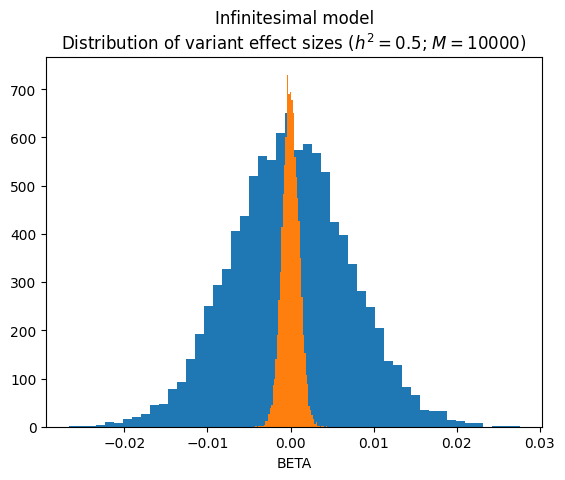

In [6]:
def sample_beta_infinitesimal(n_snps, h2, random_seed=7209):
    """
    Sample variant effect sizes (BETA) according to the
    infinitesimal model.

    :param n_snps: The number of genetic variants.
    :param h2: The heritability for the phenotype of interest (float from 0 to 1).
    :param random_seed: The seed for the random number generator.
    """

    # Sanity checks
    assert 0. <= h2 <= 1.

    per_snp_h2 = h2 / n_snps

    return np.random.normal(
        loc=0.,  # The mean
        scale=np.sqrt(per_snp_h2),  # sqrt(variance)
        size=n_snps  # The number of variants
    )

# Sample effect sizes according to the infinitesimal model
# where the heritability is set to 0.5 and the number of variants
# is set to 10k:
beta = sample_beta_infinitesimal(n_snps=10_000, h2=0.5)

# Plot a histogram of the effect sizes:
plt.hist(beta, bins=50)
plt.xlabel("BETA")
plt.title("Infinitesimal model\nDistribution of variant effect sizes ($h^2=0.5$; $M=10000$)");

# Now try simulate with smaller h2 as a comparison
plt.hist(sample_beta_infinitesimal(n_snps=10_000, h2=0.01), bins=50)

#### (1.3.2) The spike-and-slab prior

From an an evolutionary perspective, as well as given our current understanding of genetics from molecular and genetic epidemiology studies, we know that most variants have no or negligible effect on most phenotypes. This evidence and observations motivated an alternative model that gives parametric form to this "**sparsity**": The **spike-and-slab prior**.
    
The spike-and-slab is a mixture distribution: Instead of having a single Gaussian distribution from which
we draw the effect size, we are going to have two distributions:
    
* **The spike distribution** $\delta_0$: The spike distribution is a degenerate density where all of its
    weight is centered at zero. Visually, this distribution looks like a "spike" at the value zero,
    hence the name. As we'd expect, the spike distribution is used to model variants
    with no or negligible effect on the phenotype.

* **The slab distribution** $N(0, \frac{h^2}{\pi M})$: The slab distribution is a Gaussian distribution similar to
    one we encountered before with the infinitesimal model. It's called a "slab" because, visually,
    it looks flatter compared to the spike. The slab distribution is used to model variants with
    an effect on the phenotype.
    
The other component that goes into defining the spike-and-slab is a **mixing weight**, denoted by $\pi$,
that tells us **what proportion of variants come from the slab distribution** (i.e. what proportion of variants
have an effect on the phenotype). Mathematically, this is distribution is often written as:

\begin{align}
  s_j &\sim \pi^{[s_j=1]}(1-\pi)^{[s_j=0]}\\
  \beta_j &\sim s_j N(0, \frac{h^2}{\pi M}) + (1 - s_j)\delta_0
\end{align}

**NOTE**: Unlike in the infinitesimal model, the variance of the slab distribution is proportional to per-SNP heritability of causal variants (i.e. we scale $M$ by $\pi$ or $M\pi = \sum^M_{j=1}\mathbb{E}[s_j]$).

#### Data generative process

In terms of the data generative process, mixture models are usually thought of as hierarchical models:

1) Determine which mixture component the variant effect comes from:
  * This is done by sampling $s_j$ from a **Bernoulli with success probability** $\pi$.
  * If the Bernoulli draw is a success, then the variant is assigned to the slab; otherwise it's assigned to the spike.

2) Draw the effect according to the mixture component that the variant was assigned in Step 1.


To illustrate what the spike-and-slab model implies in practice, let's try and simulate it:

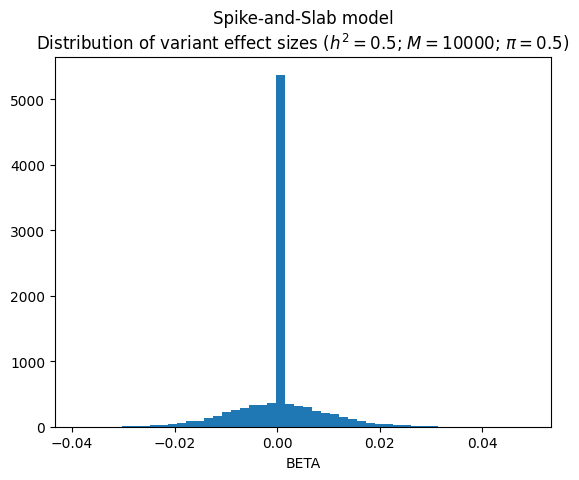

In [7]:
def sample_beta_spike_and_slab(n_snps, h2, pi, random_seed=7209):
    """
    Sample variant effect sizes (BETA) according to the
    infinitesimal model.

    :param n_snps: The number of genetic variants.
    :param h2: The heritability for the phenotype of interest (float ranging from 0 to 1).
    :param pi: The proportion of causal variants (float ranging from 0 to 1)
    :param random_seed: The seed for the random number generator.
    """

    # Sanity checks
    assert 0. <= h2 <= 1.
    assert 0. <= pi <= 1.

    per_snp_h2 = h2 / (pi*n_snps)

    # Draw mixture assignment from Bernoulli:
    # NOTE: In numpy Bernoulli sampling is done via binomial with number of trials set to 1.
    mixture_assignment = np.random.binomial(1, pi, size=n_snps)

    # NOTE: For ease of implementation, we draw effect for all variants from
    # slab, but then we zero the effect of non-slab variants

    # Draw from Gaussian:
    beta = np.random.normal(loc=0., # mean
                            scale=np.sqrt(per_snp_h2), # sqrt(var)
                            size=n_snps) # number of variants

    # Final beta:
    beta *=mixture_assignment

    return beta


# Sample betas from the spike-and-slab model:
beta = sample_beta_spike_and_slab(n_snps=10_000,
                                  h2=0.5,
                                  pi=0.5)


# Plot a histogram of the effect sizes:

plt.hist(beta, bins=50)
plt.xlabel("BETA")
plt.title(f"Spike-and-Slab model\nDistribution of variant effect sizes ($h^2={0.5}$; $M={10000}$; $\pi={0.5}$)");

### (1.4) Heritability and R-squared

The concept of heritability is defined as **the proportion of phenotypic variance attributable to genetics**:

$$
h^2 = \frac{\sigma^2_g}{\sigma^2_y}
$$

Hence, its value ranges between 0 and 1. When genetic factors explain very little of phenotypic variation in a given sample, heritability will tend towards 0. If, on the other hand, genetic factors explain most observed variation in the phenotype, its value will tend towards 1.

Another important concept to understand in this context is **narrow-sense heritability** ($h^2_A$): which is defined as the proportion of phenotypic variance explained by **additive genetic effects**. And here is where the linear model comes back again: When we talk about narrow-sense heritability, we're mainly concerned about the variance of $X\beta$ as a proportion of phenotypic variance $\sigma^2_y=Var(X\beta + \epsilon)$:

$$
h^2_A = \frac{Var(X\beta)}{\sigma^2_y}
$$

In other words, with narrow-sense heritability, we're not concerned about variation arising due to dominance, epistasis, or other non-linear genetic effects.

For the purposes of our discussions in this tutorial, heritability factors in in **two important ways**:

1) Heritability is important to define the **residual component** ($\epsilon$) in the linear model above. In most statistical genetics models, the residual effect is modelled with a Gaussian density with mean zero and variance
set to the total phenotypic variance not captured by genetics:

$$
\epsilon_i \sim N(0, \sigma^2_y*(1 - h^2))
$$

For example, if the total phenotypic variance $\sigma^2_y$ is 1 and the heritability of the phenotype is 0.5, then the variance of $\epsilon$ will simply be set to 0.5.

2) Narrow-sense heritability provides us with an **upper bound for how well we can predict the phenotype using linear models**. In statistical genetics, we often use the coefficient of determination (R-Squared or $R^2$) to evaluate model performance. R-squared is the proportion of phenotypic variance explained by the predictor:

$$
  R^2 = 1 - \frac{\sum_i(y_i-\hat{y}_i)^2}{\sum_i(y_i - \bar{y})^2}
  = 1 - \frac{SS_{res}}{SS_{tot}} \le h^2
$$

Thus, for these predictors, the $R^2$ performance is upper-bounded by narrow-sense heritability. Intuitively, if the phenotype is strongly heritable, genetic predictors can in principle perform well. On the other hand, if the phenotype is mildly heritable, prediction accuracy will be poor.

## Exercise (2): Simulating data according to the linear model

Now that we learned all about linear models, heritability, mixture distributions, and spike-and-slab priors, let's take some time to practice simulating complex traits / phenotypes. In this exercise, you'll be given genotype data for a subset of 378 European individuals from the 1000G project. For each individual, we have mutation counts at ~15,000 variants on Chromosome 22.

Your task is to simulate a phenotype for these individuals according to the following criteria:

1) The **heritability** for the phenotype should be set to $h^2 = 0.5$

2) Use the **spike-and-slab** model to simulate the effect sizes.
    * Mixing proportion $\pi$ should be set to $\pi = 0.1$ (i.e. only 10% of the variants influence the trait).
    
3) Total phenotypic variance $\sigma_y^2$ should be set to 1.

In [8]:
#@title YOUR CODE
# Let's define the parameters of the model:

h2 = 0.5  # Heritability
pi = 0.1  # Mixing proportion
sigma2_y = 1.  # Phenotypic variance

# Extract and standardize the genotype matrix:
X = g_matrix.to_numpy().astype(np.float32)
# Standardize the genotype matrix:
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Get the sample size and number of variants in
# in the genotype matrix:

n = X.shape[0] # Number of samples
n_snps = X.shape[1] # Number of variants

################ STEP 1 ################
# Sample the effect sizes from spike-and-slab:

# FILL IN HERE

################ STEP 2 ################
# Compute the polygenic score (X\beta)

# FILL IN HERE


################ STEP 3 ################
# Sample the residual component (epsilon)

# FILL IN HERE

################ STEP 4 ################
# Compute the final phenotype according to the linear model:

# FILL IN HERE

################ STEP 5 ################
# Plot the distribution of the phenotype:

# FILL IN HERE

Text(0.5, 1.0, 'Simulated phenotype distribution')

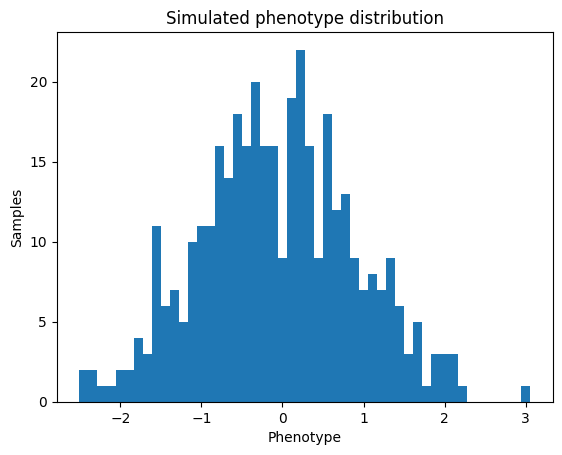

In [9]:
#@title SOLUTION (Don't look at it until you finish the exercise)
# Let's define the parameters of the model:

h2 = 0.5  # Heritability
pi = 0.1  # Mixing proportion
sigma2_y = 1.  # Phenotypic variance

# Extract and standardize the genotype matrix:
X = g_matrix.to_numpy().astype(np.float32)
# Standardize the genotype matrix:
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Get the sample size and number of variants in
# in the genotype matrix:

n = X.shape[0] # Number of samples
n_snps = X.shape[1] # Number of variants

################ STEP 1 ################
# Sample the effect sizes from spike-and-slab:

beta = sample_beta_spike_and_slab(n_snps=n_snps,
                                  h2=h2,
                                  pi=pi)

################ STEP 2 ################
# Compute the polygenic score (X\beta)

y_g = X @ beta


################ STEP 3 ################
# Sample the residual component (epsilon)

eps = np.random.normal(loc=0.,
    scale=np.sqrt(sigma2_y - h2), #std of residual
    size=n) # number of samples

################ STEP 4 ################
# Compute the final phenotype according to the linear model:

y = y_g + eps

################ STEP 5 ################
# Plot the distribution of the phenotype:
plt.hist(y, bins=50)
plt.xlabel("Phenotype")
plt.ylabel("Samples")
plt.title("Simulated phenotype distribution")

## (2) Simulating Complex Traits using `magenpy`

Now that we understand the data generative process better, we can avoid having to do this low-level work
ourselves and instead delegate it to [magenpy](https://shz9.github.io/magenpy/). `magenpy` is a `python` package for statistical genetics applications and it supports various phenotype simulation tools.

For example, to simulate a phenotype with the same parameters as the exercise above, we can simply invoke:

> Reading genotype metadata...
> Generating polygenic scores...


,FID,IID,phenotype
0,HG00096,HG00096,1.412844
1,HG00097,HG00097,0.178778
2,HG00099,HG00099,-0.346534
3,HG00100,HG00100,-0.531910
4,HG00101,HG00101,-1.722824
...,...,...,...
373,NA20815,NA20815,0.736829
374,NA20818,NA20818,-0.876931
375,NA20819,NA20819,0.208573
376,NA20826,NA20826,-0.758937


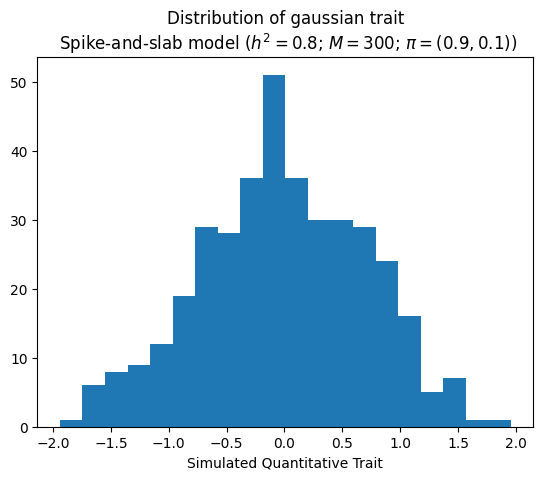

In [10]:
# Sed random seed:
np.random.seed(7209)

# Initialize the simulator object:
sim = mgp.PhenotypeSimulator(mgp.tgp_eur_data_path(),
                             min_mac=10,
                             h2=0.8,
                             pi=0.1)
# Filter to a smaller subset of variants:
sim.filter_snps(sim.snps[22][:300])

# Simulate a phenotype:
sim.simulate()

# Get a table with the simulated phenotype:
pheno_table = sim.to_phenotype_table()

# Display the phenotype table:
display(pheno_table)

# Plot a histogram of the simulated phenotype:

plt.hist(pheno_table.phenotype, bins=20)
plt.xlabel("Simulated Quantitative Trait")
plt.title(f"Distribution of {sim.phenotype_likelihood} trait\n Spike-and-slab model ($h^2={sim.h2}$; $M={sim.n_snps}$; $\pi={sim.pi}$)");

In addition to saving the simulated phenotype for us, we can also examine the simulated effect sizes and the
results of the simulation from the spike-and-slab prior. To be specific, the package records which mixture
component each variant was assigned to, its per-SNP heritability, its sampled effect size ($\beta$), and whether it comes from the a non-spike mixture component (`Causal` column):

,CHR,SNP,A1,A2,MixtureComponent,Heritability,BETA,Causal
0,22,rs131538,A,G,0,0.0,0.0,False
1,22,rs9605903,C,T,0,0.0,0.0,False
2,22,rs5746647,G,T,0,0.0,0.0,False
3,22,rs16980739,T,C,0,0.0,0.0,False
4,22,rs9605923,A,T,0,0.0,0.0,False
...,...,...,...,...,...,...,...,...
295,22,rs12160031,A,G,0,0.0,0.0,False
296,22,rs5749022,C,G,0,0.0,0.0,False
297,22,rs5749028,G,A,0,0.0,0.0,False
298,22,rs4819996,A,G,0,0.0,0.0,False


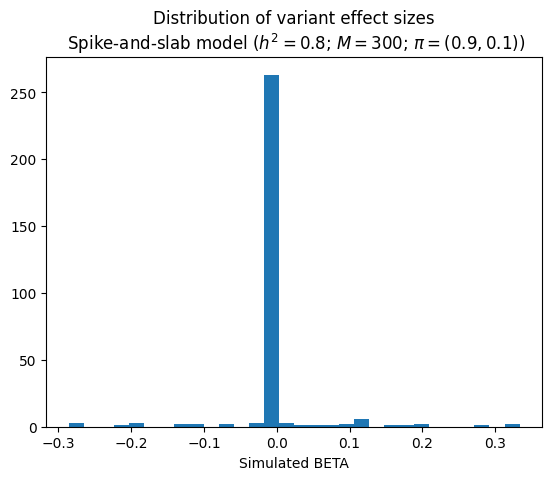

In [11]:
# Get the simulated BETAs:
effect_table = sim.to_true_beta_table()

# Display the table of effect sizes:
display(effect_table)

# Plot the distribution of simulated BETAs:
plt.hist(effect_table.BETA, bins=30)
plt.xlabel("Simulated BETA")
plt.title(f"Distribution of variant effect sizes\n Spike-and-slab model ($h^2={sim.h2}$; $M={sim.n_snps}$; $\pi={sim.pi}$)");

### Train / test split

One useful feature that `magenpy` provides is to allow us to split the simulated data into independent training
and test sets, which we can use for robustly evaluating the predictive performance of PRS models. This can be done
by simply invoking the `.split_by_samples()` method on the simulated data:

In [12]:
# Set random seed:
np.random.seed(7209)

# Split the simulated data into 75% training and 25% testing:
train, test = sim.split_by_samples([0.75, 0.25])

# Print the number of samples in the training and test sets:
print("Number of samples in training set:", train.n)
print("Number of samples in the test set:", test.n)

# To streamline following steps, extract input / output data:

# Training data:
X_train = train.genotype[22].to_numpy()
y_train = train.sample_table.phenotype

# Test data:
X_test = test.genotype[22].to_numpy()
y_test = test.sample_table.phenotype

Number of samples in training set: 272
Number of samples in the test set: 106


## (3) Inference of Polygenic Risk Scores (PRS) from Individual-level Data

Now that we understand better the concepts underlying polygenic risk scores, let us turn to how we might go
about estimating them from biobank data. **In practical terms, inferring polygenic scores means obtaining an estimate for the weights of the linear model $\beta$**.

### (3.1) Multiple Linear Regression

The straightforward approach for performing inference in this context is to simply **fit a linear model to paired genotype and phenotype data**. The optimal $\beta$s are those the minimize the **mean squared error** across across individuals in the training set:

$$
MSE = \frac{1}{N} \sum_{i=1}^N (y_i - X_i\beta)^2
$$

How is this achieved in practice? Solving the above objective function for the $\beta$s gives a closed-form solution:

$$
\hat{\beta} = (X^\top X)^{-1}(X^\top y)
$$

In `python`, this can be done in a variety of ways, but here we will show you how to do it using the popular `scikit-learn` package. `scikit-learn` provides a variety of interfaces for fitting
linear models to data, all of them under than `sklearn.linear_model` module.

Let's start by first fitting a simple linear model to our data:

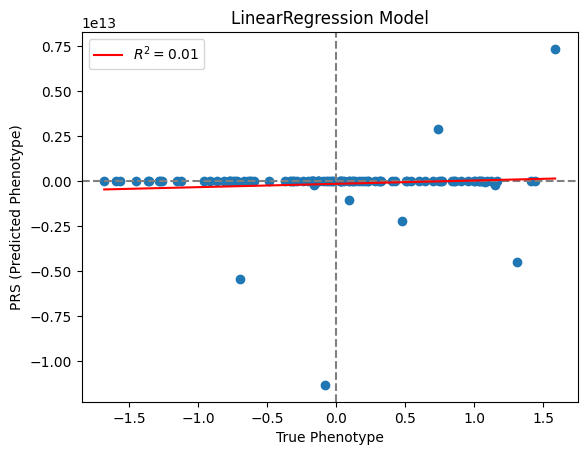

In [13]:
# Import the LinearRegression module:
from sklearn.linear_model import LinearRegression

# ------------ Model fitting ------------
# Initialize the LinearRegression object:
prs_lm = LinearRegression()
# Fit the model to the training data:
prs_lm.fit(X_train, y_train)

# ------------ Evaluation ------------

def plot_scatter(true, pred, title=None):
    """
    Helper function to plot the PRS vs. phenotype
    and display the R-Squared metric.
    """

    from scipy.stats import linregress
    b, a, r_val, _, _ = linregress(true, pred)

    x = np.linspace(true.min(), true.max(), 100)

    # Add zero lines:
    plt.axvline(0., ls='--', color='gray')
    plt.axhline(0., ls='--', color='gray')
    # Plot true vs. predicted:
    plt.scatter(true, pred)

    # Plot the fitted line:
    plt.plot(x, x*b + a, label=f"$R^2 = {round(r_val**2, 2)}$", c='red')

    # Add labels / title:
    plt.xlabel("True Phenotype")
    plt.ylabel("PRS (Predicted Phenotype)")
    plt.legend()
    if title is not None:
        plt.title(title)

# Predict on the test set:
prs_lm_pred = prs_lm.predict(X_test)

# Let's compare the model prediction to the simulated phenotypes:
plot_scatter(y_test, prs_lm_pred, title="LinearRegression Model")

As we see in the example above, a major limitation of the using the vanilla linear model outlined above is that, given the high-dimensionality of genetic data and the strong correlations (Linkage-Disequilibrium - LD) between genetic variants, the solution often becomes becomes ill-defined. This usually happens in general regression contexts where the number of features is much larger than the number of samples and where the features can be highly correlation with each other (**multicollinearity**).

**Intuition**: Why the solution fails? Recall the solution to the system of linear equations is:


$$
\hat{\beta} = (X^\top X)^{-1}(X^\top y)
$$

This solution assumes that the $X^\top X$ matrix (e.g. LD matrix) is invertible. However, when the number of features is much larger than the number of samples or there are highly correlated features, this matrix is no longer invertible, as we can verify with `numpy`:

In [14]:
# Attempt to invert the X'X matrix:
# np.linalg.inv(X_train.T.dot(X_train)) # LinAlgError

### (3.2) Regularized Linear Regression

A standard way to resolve these issues with the linear model in practice is to use **regularization techniques**, such as **Ridge regression** or the **Lasso**. Regularization provides a way to incorporate preference for sparse or small effect sizes when solving for the optimal $\beta$S. This is typically done by adding a "penalty" on the values of the effect sizes to the optimization objective:  

$$
\text{Ridge objective:} \frac{1}{N} \sum_{i=1}^N (y_i - X_i\beta)^2 + \alpha \underbrace{\sum_{j=1}^M \beta^2_j}_{Penalty}
$$

$$
\text{Lasso objective:} \frac{1}{N} \sum_{i=1}^N (y_i - X_i\beta)^2 + \alpha \underbrace{\sum_{j=1}^M |\beta_j|}_{Penalty}
$$

Here, the parameter $\alpha$ determines the strength of the penalty. Larger $\alpha$ will tend to impose stronger shrinkage on the effect sizes. In `scikit-learn`, fitting regularized models can be done in very similar ways to what we have seen before:

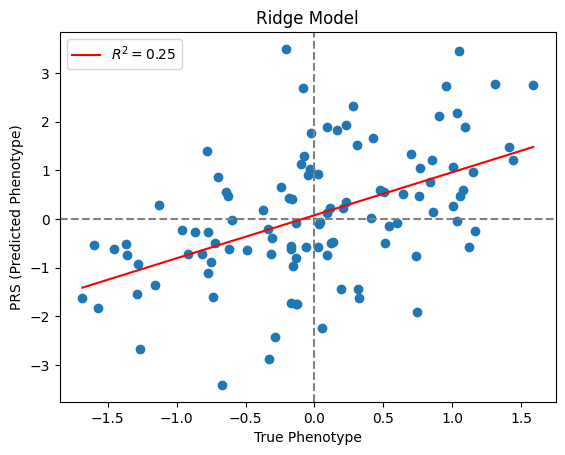

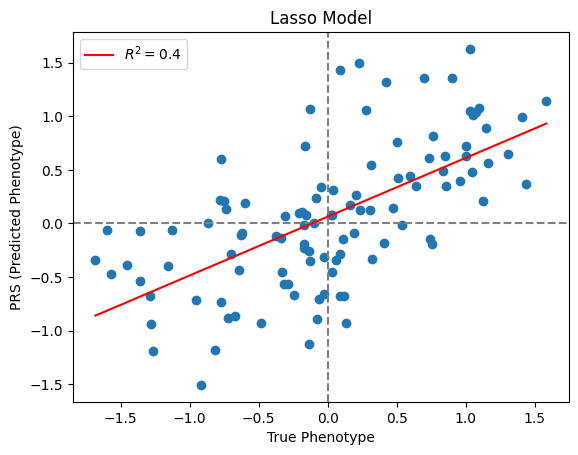

In [15]:
from sklearn.linear_model import Ridge, Lasso

# ------------ Model fitting ------------
# Initialize the Ridge object:
prs_ridge = Ridge(alpha=1e-3)
# Fit the model to the training data:
prs_ridge.fit(X_train, y_train)

# Initialize the Lasso object:
prs_lasso = Lasso(alpha=1e-3)
# Fit the model to the training data:
prs_lasso.fit(X_train, y_train)

# ------------ Evaluation ------------

# Predict on the test set:
prs_ridge_pred = prs_ridge.predict(X_test)
prs_lasso_pred = prs_lasso.predict(X_test)

# Let's compare the model prediction to the simulated phenotypes:
plot_scatter(y_test, prs_ridge_pred, title="Ridge Model")
plt.show()
plot_scatter(y_test, prs_lasso_pred, title="Lasso Model")


### Existing PRS Methods that operate on individual-level data

* [bayesR](https://github.com/syntheke/bayesR)
* [snpnet](https://github.com/junyangq/snpnet)

## (4) Inference of Polygenic Risk Scores (PRS) from GWAS Summary Statistics

While individual-level data is valuable and offers the best and most straightforward way to infer accurate polygenic scores, in many cases, access to this data is restricted due to privacy or other concerns. Even when large-scale individual-level data is available, as in the case of the UK Biobank, we'd usually be restricted to using one biobank or one data source at a time for performing inference, which can severely limit the sample sizes that can be obtained. These concerns, among others, motivated researchers to develop ways to infer polygenic scores from GWAS summary statistics alone. The benefits of this are:

1) **Protect individual privacy**: No need to access individual-level data. These analyses can be done via publicly available data only.
2) **Larger sample sizes**: Can Leverage much larger sample sizes via meta-analysis of many smaller GWAS studies.
3) **Computational efficiency**: It can be much faster and computationally efficient to infer polygenic scores in this way.


### Intuition

To see how polygenic scores can be inferred from GWAS summary statistics, let us turn back to the solution of the linear model we discussed previously:

$$
\hat{\beta} = (X^\top X)^{-1}(X^\top y)
$$

Here, we see that the solution depends on two quantities:

* **The Linkage-Disequilibrium (LD) matrix** $X^\top X$: This quantity is roughly similar across individuals of same ancestry, which means we can use publicly available data (e.g. 1000G Project) to estimate it.
* **GWAS Summary Statistics** ($X^\top y$): A measure that tells us about the correlation of the phenotype with each position in the genome. This can be approximated via Z-scores or p-values from GWAS studies.


<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/sumstats.png?raw=1" alt="drawing" width="750"/>

In order for us to perform PRS inference from GWAS summary statistics, let's first go ahead and compute the LD matrix and perform GWAS on the training data:

> Performing GWAS...
> Computing LD matrix...


Text(0, 0.5, '-log10(P-Value)')

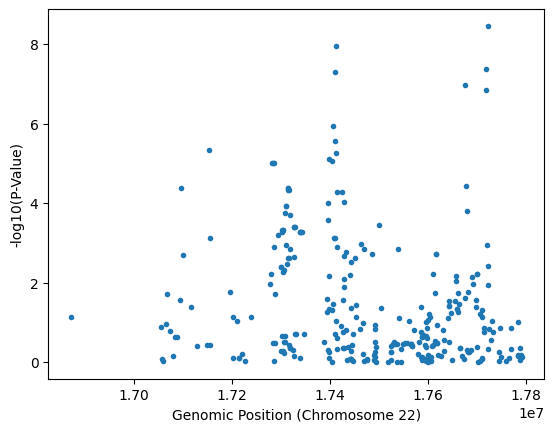

In [16]:
# Perform GWAS on the training data only:
train.perform_gwas()

# Compute LD matrix from training samples:
train.compute_ld('sample',
                 output_dir='./',
                 dtype='float32')

# -------- Visualize GWAS results: --------

# Get GWAS summary statistics table:
sumstats_table = train.to_summary_statistics_table()
plt.scatter(sumstats_table.POS, -np.log10(sumstats_table.PVAL), marker='.')
plt.xlabel("Genomic Position (Chromosome 22)")
plt.ylabel("-log10(P-Value)")

### (4.1) Naive PRS

In the initial work on PRS leveraging GWAS summary statistics, the first approach simply used the marginal $\beta$s inferred by the GWAS as the PRS weights. To be concrete, if the marginal betas from the GWAS are denoted as $\beta^{(GWAS)}$s, then the PRS prediction under this model is simply:

$$
\hat{PRS}_i = \sum_{j=1}^M X_{ij}\beta^{(GWAS)}_j
$$

Since we just performed a GWAS, we can use the marginal BETAs to perform the prediction and see how well this approach fares in practice:

> Generating polygenic scores...


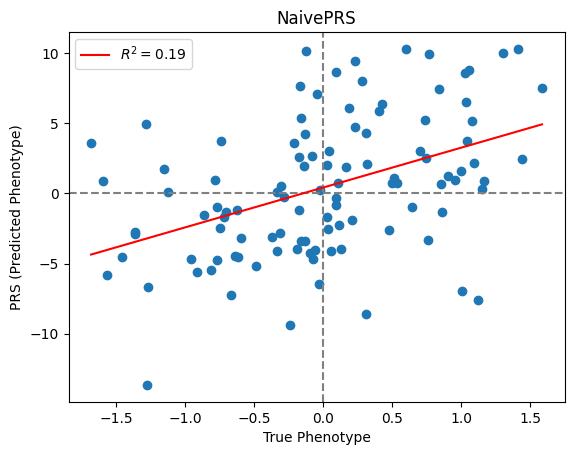

In [17]:
# Score using the marginal BETAs:

naive_prs_pred = test.predict({22: train.sumstats_table[22].marginal_beta})

# Let's compare the model prediction to the simulated phenotypes:
plot_scatter(y_test, naive_prs_pred, title="NaivePRS")

As we can see, the `NaivePRS` approach is not as accurate as the models we derived from individual-level data. This is because this model assumes an infinitesimal architecture where all variants are causal and does not account for the fact that genetic variants tend to be highly correlated with each other. The latter fact implies that some non-causal variants may have large marginal effects by virtue of being correlated with a causal variant nearby in the genome.

### (4.2) Clumping + Thresholding (C+T)

An alternative approach to using all the marginal BETAs from GWAS is to restrict to **genome-wide significant variants**, e.g. those that pass the Bonferroni-correct P-Value threshold of $\sim 5^{-8}$ (or some other user-provided threshold). This procedure is known as "**Thresholding**", because for variants that are above the p-value threshold, their effects will be set to zero.

Thresholding on its own, however, will not tackle the issue of variants in a locus being highly correlated. So, the other procedure that we need to perform here is "**Clumping**", where, in each locus, we remove variants that are highly correlated (e.g. $r^2 > 0.9$) with the lead variant in that locus.

In summary, for this method to work, the user has to specify **two parameters**:

1) The P-value threshold for selecting "significant" variants.

2) The $r^2$ threshold for clumping variants in LD with the lead variant.

<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/PT.png?raw=1" alt="drawing" width="800"/>

The following code implements this using the GWAS data we derived earlier:

Variants remaining after Clumping + Thresholding:


,CHR,SNP,POS,A1,A2,MAF,N,BETA,Z,SE,PVAL,Keep_T,Keep_C,Keep_Final,CT_BETA
16,22,rs4819849,17152611,G,A,0.362132,272,0.271026,4.581396,0.059158,4.618815e-06,True,True,True,0.271026
30,22,rs738045,17281931,A,G,0.281250,272,0.284128,4.420265,0.064278,9.857992e-06,True,True,True,0.284128
91,22,rs7292561,17398508,C,T,0.351103,272,0.260404,4.470429,0.058250,7.806295e-06,True,True,True,0.260404
96,22,rs887755,17404605,G,A,0.384191,272,-0.263676,-4.449519,0.059259,8.606278e-06,True,True,True,-0.263676
98,22,rs5992587,17407349,T,C,0.415441,272,-0.282112,-4.861582,0.058029,1.164513e-06,True,True,True,-0.282112
104,22,rs5992589,17410790,A,G,0.334559,272,-0.325247,-5.447235,0.059709,5.115872e-08,True,True,True,-0.325247
106,22,rs9605179,17412216,G,A,0.373162,272,0.265622,4.541590,0.058487,5.583161e-06,True,True,True,0.265622
249,22,rs5992637,17675900,A,C,0.395221,272,-0.317252,-5.318850,0.059647,1.044252e-07,True,True,True,-0.317252
274,22,rs5747035,17718606,C,T,0.068015,272,0.607540,5.478188,0.110902,4.297024e-08,True,True,True,0.607540
275,22,rs5748976,17718911,C,G,0.066176,272,0.609581,5.263391,0.115815,1.414221e-07,True,True,True,0.609581


> Generating polygenic scores...


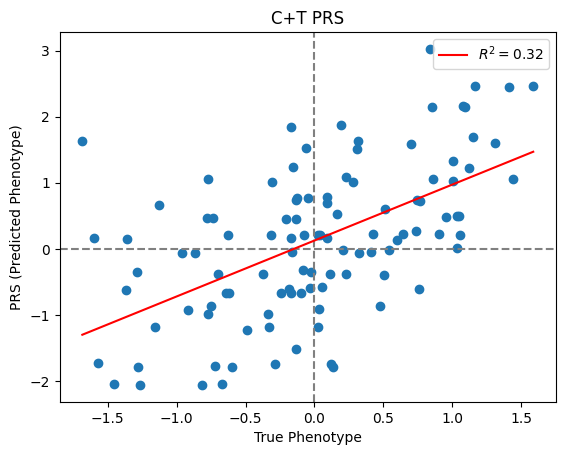

In [18]:
# Import helper function to performing clumping:
from magenpy.stats.ld.utils import clump_snps

# Set the thresholds:
pval_threshold = 1e-5
rsq_threshold = 0.9

# Step 1: Find which variants to keep by thresholding based on P-values:
sumstats_table = train.to_summary_statistics_table()
sumstats_table['Keep_T'] = sumstats_table.PVAL < pval_threshold

# Step 2: Find which variants to keep after clumping variants that are highly correlated:
clumped_snps = clump_snps(train.ld[22],
                          statistic=sumstats_table.PVAL,
                          rsq_threshold=rsq_threshold)
# Create a dataframe with the clumped SNPs:
clumped_snps = pd.DataFrame({'SNP': clumped_snps, 'Keep_C': True})
# Merge with the original sumstats table:
sumstats_table = sumstats_table.merge(clumped_snps, how='left').fillna(False)

# Step 3: Combine both conditions:
sumstats_table['Keep_Final'] = sumstats_table['Keep_T'] & sumstats_table['Keep_C']

# Step 4: Compute the final BETA by taking into account both Clumping + Thresholding
sumstats_table['CT_BETA'] = sumstats_table.BETA * sumstats_table.Keep_Final

# Display the variants remaining after Clumping + Thresholding:

print("Variants remaining after Clumping + Thresholding:")
display(sumstats_table.loc[sumstats_table.Keep_Final])

# Score using the C+T betas:

ct_prs_pred = test.predict({22: sumstats_table.CT_BETA})

# Let's compare the model prediction to the simulated phenotypes:
plot_scatter(y_test, ct_prs_pred, title="C+T PRS")

### (4.3) Bayesian PRS (`VIPRS`)

The final major category of approaches that we will discuss in this context are those that use Bayesian inference techniques to infer polygenic risk score weights from GWAS summary statistics. Bayesian PRS methods operate by specifying priors distributions on the effect size, specifying the data likelihood, and then performing approximate Bayesian inference using Markov Chain Monte Carlo (MCMC) or Variational Inference (VI).

In this presentation, we will discuss our recently proposed method for Bayesian PRS inference: **VIPRS**. `VIPRS` assigns a spike-and-slab prior on the effect size, as discussed in the previous section. Then, in order to approximate the Bayesian posterior, the method employs variational inference techniques to achieve fast and accurate posterior approximation. This is in contrast to many popular Bayesian PRS methods, which use Markov Chain Monte Carlo (MCMC) for posterior approximation.

<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/mcmc.png?raw=1" alt="drawing" width="700"/>

<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/vi.png?raw=1" alt="drawing" width="700"/>


`VIPRS` was developed in conjunction with `magenpy`, so the interfaces should work together quite nicely. To perform inference on the summary statistics that we derived previously, you only need to pass the `train` object to `VIPRS` and then call `.fit` method:

Chromosome 22 (300 variants):   0%|          | 0/1000 [00:00<?, ?it/s]

> Generating polygenic scores...


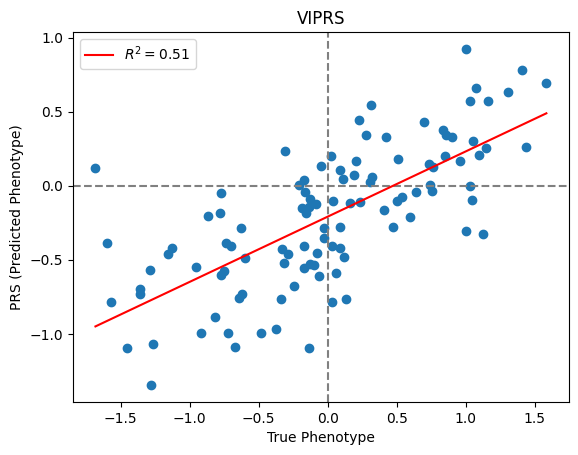

In [19]:
# Initialize the VIPRS object:
v = vp.VIPRS(train, low_memory=True)
# Fit the model to data:
v.fit()

# Predict on the test samples:
viprs_pred = v.predict(test)

# Let's compare the model prediction to the simulated phenotypes:
plot_scatter(y_test, viprs_pred, title="VIPRS")

In addition to the prediction accuracy on the held-out test set, we can also interrogate and inspect the behavior of the `VIPRS` model by examining the **Evidence Lower BOund (ELBO)**, the metric that the model is aiming to maximize:

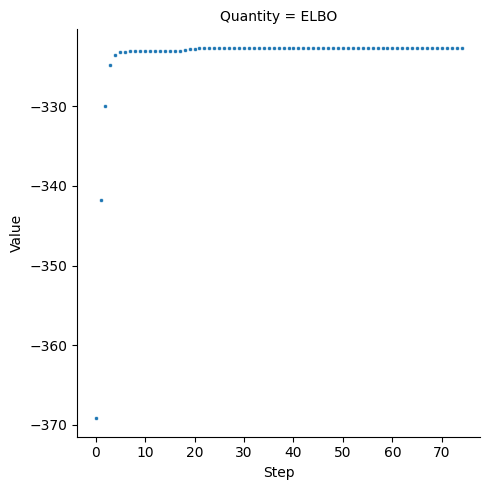

In [20]:
from viprs.plot.diagnostics import plot_history

plot_history(v)

One advantage of Bayesian methods like `VIPRS` is that we can also obtain interpretable outputs, such as
the probability for given variant being causal for the phenotype of interest. This quantity is known in the
literature as **Posterior Inclusion Probability (PIP)**. Since our phenotype here is simulated and we
have a record of the true causal variants, we can compare the estimated **PIPs** to the causal status of the variants in the simulation:

,CHR,SNP,POS,A1,A2,BETA,PIP,VAR_BETA
0,22,rs131538,16871137,A,G,0.002283,0.038480,0.000183
1,22,rs9605903,17054720,C,T,-0.000257,0.012718,0.000023
2,22,rs5746647,17057138,G,T,-0.000538,0.016258,0.000040
3,22,rs16980739,17058616,T,C,0.000198,0.012088,0.000020
4,22,rs9605923,17065079,A,T,-0.000267,0.012826,0.000023
...,...,...,...,...,...,...,...,...
295,22,rs12160031,17784602,A,G,-0.000989,0.022260,0.000073
296,22,rs5749022,17787836,C,G,0.001333,0.026737,0.000101
297,22,rs5749028,17789010,G,A,-0.000237,0.012490,0.000022
298,22,rs4819996,17790731,A,G,-0.000270,0.012860,0.000023


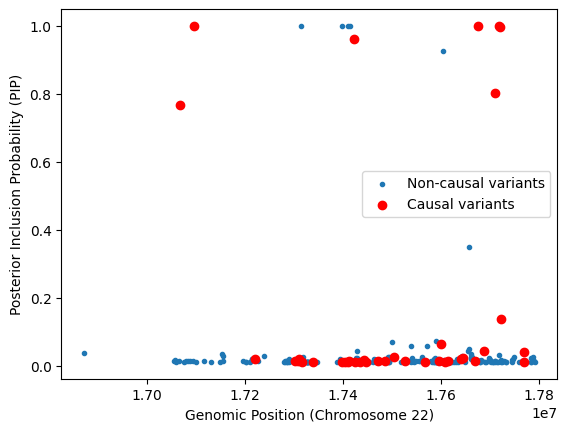

In [21]:
# Export the inferred variant effect sizes:
post_effect_table = v.to_table(col_subset=('CHR', 'SNP', 'POS', 'A1', 'A2'))

display(post_effect_table)

# Plot the Posterior Inclusion Probability (PIP):
plt.scatter(post_effect_table.POS, post_effect_table.PIP,
            marker='.', label='Non-causal variants')
mask = train.get_causal_status()[22]
plt.scatter(post_effect_table.POS[mask], post_effect_table.PIP[mask], color='red',
            label='Causal variants')
plt.xlabel("Genomic Position (Chromosome 22)")
plt.ylabel("Posterior Inclusion Probability (PIP)")
plt.legend();

### Other established PRS Methods that operate on GWAS Summary Statistics


#### Bayesian:
* [LDPred2](https://privefl.github.io/bigsnpr/articles/LDpred2.html)
* [SBayesR](https://cnsgenomics.com/software/gctb/#Overview)
* [PRScs](https://github.com/getian107/PRScs)

#### Regularized Linear Models
* [Lassosum](https://github.com/tshmak/lassosum)

#### C+T
* [plink2](https://www.cog-genomics.org/plink/2.0/)
* [PRSice2](https://choishingwan.github.io/PRSice/)




## (5) PRS Evaluation Strategies / Metrics

Once a PRS model is fit to data, the next step is to evaluate its prediction accuracy on a held-out test set. Accuracy is measured differently depending on the type of phenotype considered (continuous vs. binary) as well as the data available about the validation / test cohort.


For **continuous phenotypes**, common evaluation metrics include:

* **Pearson Correlation Coefficient**: Measure the correlation between the PRS and the phenotype.
* **R-Squared (Coefficient of Determination)**: The proportion of phenotypic variance expalined by the PRS.
   * **Incremental R-Squared**: In research papers on PRS, the most common metric is incremental R-Squared, which takes the difference between the $R^2$ of a null model (with no PRS) and a full model with the PRS included. The null model is typically a linear model with only covariates (sex, age, Pricipal Components - PCs), whereas the full model is a linear model with these covariates plus the PRS:
   
   **Null model**: $y \sim \alpha_0 + \sum_{c=1}^C C_k*\beta_c$
   
   **Full model**: $y \sim \alpha_0 + PRS*\beta_{prs} + \sum_{c=1}^C C_k*\beta_c$


<img src="https://github.com/yueliyl/viprs-tut/blob/main/figures/r2.png?raw=1" alt="drawing" width="500"/>


For **binary, case-control phenotypes**, common evaluation metrics include:

* **Area Under the ROC Curve (AUROC)**: A measure of separability between cases and controls that ranges between 0.5 (random predictor) and 1 (perfect separability).
* **Nagelkerke R-Squared**: A pseudo R-squared metric that works for binary traits (https://en.wikipedia.org/wiki/Pseudo-R-squared).
* **Liability R-Squared**: A pseudo R-squared metric that is less biased than Nagelkerke (Lee et al., 2012).

Reference:
Lee, S. H., Goddard, M. E., Wray, N. R., & Visscher, P. M. (2012). A better coefficient of determination for genetic profile analysis. Genetic epidemiology, 36(3), 214-224.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1920px-Roc_curve.svg.png" alt="drawing" width="400"/>

Source: [Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

These metrics provide an estimate of the predictive performance of the PRS methods. Many of these metrics are available with the `viprs` package and can be accessed as follows:

In [22]:
# import continuous metrics:

from viprs.eval.continuous_metrics import incremental_r2, pearson_r

print("Pearson Correlation (VIPRS):", pearson_r(y_test, viprs_pred))

# NOTE: In this case, because we don't have covariates, the null model
# is a model with only intercept:
print("Incremental R-Squared (VIPRS):", incremental_r2(y_test, viprs_pred))


Pearson Correlation (VIPRS): 0.7125265822642868
Incremental R-Squared (VIPRS): 0.5076941304332258


A full listing of PRS evaluation metrics and their implementation in `python` is available [here](https://shz9.github.io/viprs/api/overview/#model-evaluation).

## (6) Inference of Polygenic Risk Scores (PRS) from Publicly Available GWAS Summary Statistics

Refer to https://colab.research.google.com/github/yueliyl/viprs-tut/blob/main/height_example.ipynb

For commandline tools, refer to tutorials / references on the `viprs` [documentation](https://shz9.github.io/viprs/) page.

## References / Further reading

* [Common polygenic variation contributes to risk of schizophrenia and bipolar disorder](https://doi.org/10.1038/nature08185)
* [PRSice-2: Polygenic Risk Score software for biobank-scale data](https://doi.org/10.1093/gigascience/giz082)
* [A guide to performing Polygenic Risk Score analyses](https://doi.org/10.1101/416545)
* [Polygenic risk scores: from research tools to clinical instruments](https://doi.org/10.1186/s13073-020-00742-5)
* [Modeling Linkage Disequilibrium Increases Accuracy of Polygenic Risk Scores](https://doi.org/10.1016%2Fj.ajhg.2015.09.001)
* [LDpred2: better, faster, stronger](https://doi.org/10.1093/bioinformatics/btaa1029)
* [Polygenic prediction via Bayesian regression and continuous shrinkage priors](https://doi.org/10.1038/s41467-019-09718-5)
* [Improved polygenic prediction by Bayesian multiple regression on summary statistics](https://doi.org/10.1038/s41467-019-12653-0)
* [Fast and accurate Bayesian polygenic risk modeling with variational inference](https://doi.org/10.1016/j.ajhg.2023.03.009)
* [A fast and scalable framework for large-scale and ultrahigh-dimensional sparse regression with application to the UK Biobank](https://doi.org/10.1371/journal.pgen.1009141)
* [Scalable Variational Inference for Bayesian Variable Selection in Regression, and Its Accuracy in Genetic Association Studies](https://doi.org/10.1214/12-BA703)